In [17]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np

from tqdm import tqdm

from zeste_vision.data_tools.loader import get_test_video_frames


In [18]:
DRAWING = mp.solutions.drawing_utils
POSE_CONNECTIONS = mp.solutions.pose.POSE_CONNECTIONS

MEDIAPIPE_OPTIONS = {
    "static_image_mode": False,
    "model_complexity": 1,
    "smooth_landmarks": True,
    "enable_segmentation": False,
    "smooth_segmentation": True,
    "min_detection_confidence": 0.5,
    "min_tracking_confidence": 0.5
}

In [19]:
def test(frame_i: int = 10):
    print("occlusion_analysis::test: loading frames")
    frames = get_test_video_frames()
    print("occlusion_analysis::test: frames loaded")

    # get test frame
    test_frame = frames[frame_i]
    rgb_frame = cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_frame)

    # instantiate pose estimator
    pose = mp.solutions.pose.Pose(**MEDIAPIPE_OPTIONS)

    # run pose estimator on test frame
    results = pose.process(test_frame)
    print("occlusion_analysis::test: pose estimation complete")

    render_image = test_frame.copy()
    DRAWING.draw_landmarks(render_image, results.pose_landmarks, POSE_CONNECTIONS)

    rgb_render_image = cv2.cvtColor(render_image, cv2.COLOR_BGR2RGB)

    plt.imshow(rgb_render_image)

occlusion_analysis::test: loading frames
occlusion_analysis::test: frames loaded
occlusion_analysis::test: pose estimation complete


I0000 00:00:1730153570.288523  905328 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1730153570.372858  906159 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
W0000 00:00:1730153570.414018  906146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730153570.432060  906148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


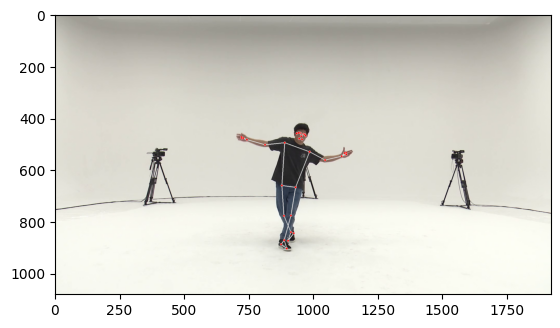

In [20]:
test()